# MLC Challenge 4 - Unsupervised Motif Discovery

In [1]:
# Import all libraries needed for the challenge
# General syntax to import specific functions in a library: 
##from (library) import (specific library function)
# General syntax to import a library but no functions: 
##import (library) as (give the library a nickname/alias)

from pandas import DataFrame, read_csv
from scipy.stats import norm
from scipy import optimize
from scipy import spatial
from numpy.random import normal
from numpy import arange, sin, pi

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math
import pandas as pd #this is how I usually import pandas
import sys #only needed to determine Python version number
import numpy as np
import matplotlib.font_manager as fm
import os
import os.path
from matplotlib.pyplot import figure, show
import datetime,time
import scipy.io as sio

#import pylab as py
import matplotlib.pylab as pylab
# Enable inline plotting
%matplotlib inline

In [2]:
pylab.rcParams['figure.figsize'] = 16, 6  # that's default image size for this interactive session

In [3]:
print ('Python version: ' + sys.version)

Python version: 3.4.3 (default, Nov 17 2016, 01:08:31) 
[GCC 4.8.4]


In [4]:
print ('Pandas version: ' + pd.__version__)

Pandas version: 0.13.1


Initial checks of path and folders availability

In [5]:
pwd

'/home/adrianderungs/Uni Passau/Students/MLC201617/Code_Data'

In [6]:
PATH = os.path.join(u'/home/adrianderungs/Uni Passau/Students/MLC201617/Code_Data/RandomTimeSeries.dat')

In [7]:
PATH

'/home/adrianderungs/Uni Passau/Students/MLC201617/Code_Data/RandomTimeSeries.dat'

In [8]:
ls

ActivityDense.mat   ECG_ref.mat           Real.dat       RealLifeY.mat
ActivitySparse.mat  Motif.ipynb           _RealLife.mat  TimeSeries.png
Approach.png        OwnTimeSeries.mat     RealLife.mat
ECG_abn.mat         RandomTimeSeries.dat  RealLifeX.dat


In [9]:
os.path.exists(PATH)

True

In [10]:
os.path.isfile(PATH)

True

## Load of data sets

Different methods for loading data - the most convenient way is by using the loadmat function provided by scipy.

In [11]:
RandomTS = np.fromfile('/home/adrianderungs/Uni Passau/Students/MLC201617/Code_Data/RandomTimeSeries.dat',dtype=float)

In [23]:
DataAndLabelsRandom = sio.loadmat('/home/adrianderungs/Uni Passau/Students/MLC201617/Code_Data/OwnTimeSeries.mat')['OwnTimeSeries']

In [24]:
DataAndLabelsRandom

array([[ 0.        ,  1.        ],
       [ 0.09983342,  1.        ],
       [ 0.19866933,  1.        ],
       ..., 
       [ 2.        ,  6.        ],
       [ 2.        ,  6.        ],
       [ 2.        ,  6.        ]])

In [25]:
type(DataAndLabelsRandom)

numpy.ndarray

In [26]:
RandomTSData = DataAndLabelsRandom[:,0]
RandomTSData

array([ 0.        ,  0.09983342,  0.19866933, ...,  2.        ,
        2.        ,  2.        ])

In [27]:
RandomTSLabels = DataAndLabelsRandom[:,1]
RandomTSLabels

array([ 1.,  1.,  1., ...,  6.,  6.,  6.])

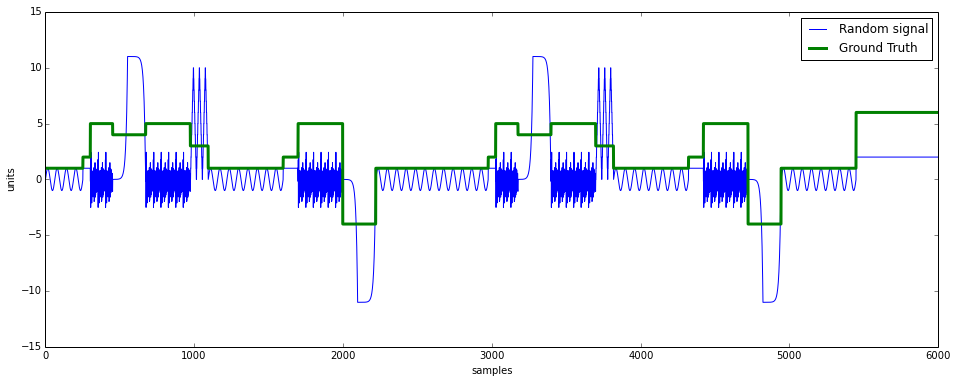

In [29]:
plt.plot(RandomTSData, label = "Random signal")
plt.plot(RandomTSLabels, label = "Ground Truth", linewidth = 3)
plt.legend()
plt.xlabel('samples')
plt.ylabel('units')
plt.show()

In [30]:
matplotlib.colors.ColorConverter.colors['mc1'] = (0.976,0.333,0.518)

In [31]:
ECG_ref = sio.loadmat('/home/adrianderungs/Uni Passau/Students/MLC201617/Code_Data/ECG_ref.mat')['ECG_ref']
ECG_abn = sio.loadmat('/home/adrianderungs/Uni Passau/Students/MLC201617/Code_Data/ECG_abn.mat')['ECG_abn']

In [32]:
#ECG_ref
type(ECG_ref)

numpy.ndarray

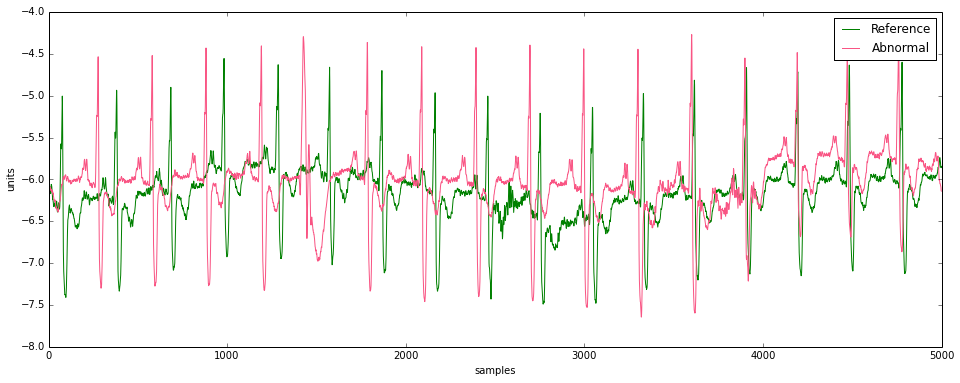

In [33]:
plt.plot(ECG_ref, label = "Reference", color = 'g')
plt.plot(ECG_abn, label = "Abnormal",color = 'mc1')
plt.xlabel('samples')
plt.ylabel('units')
plt.legend()
plt.show()

### Here are the commands for loading the two data sets "ActivitySparse" and "ActivityDense" which you will use for the analysis and the report. Please adapt the code according to your needs.

In [36]:
Data = sio.loadmat('/home/adrianderungs/Uni Passau/Students/MLC201617/Code_Data/ActivitySparse.mat')['ActivitySparse']

In [37]:
Data = sio.loadmat('/home/adrianderungs/Uni Passau/Students/MLC201617/Code_Data/ActivityDense.mat')['ActivityDense']

In [38]:
print(Data.dtype)

object


In [39]:
DataAndLabels = Data[0,0]

In [40]:
type(DataAndLabels)

numpy.ndarray

In [41]:
RealLife = DataAndLabels[:,0]
RealLife

array([ 0.        ,  0.        ,  0.        , ..., -0.88819321,
       -1.11999643, -1.274617  ])

In [42]:
Labels = DataAndLabels[:,1]
Labels

array([ 6.,  6.,  6., ...,  2.,  2.,  2.])

In [43]:
SegmentList = Data[:,1] # or use RealLife[0,1]

### Ground truth information

The SegmentList contains the information of the labels (Ground Truth) as followed:

| 1. Col.  |  2. Col. |  3. Col. | 4. Col. | 5. Col.      | 6. Col.    |
|----------|:--------:|---------:|--------:|-------------:|-----------:|
| Start    |  End     | Duration | Label   | runing Index | Confidence |

The SegmentList contains the information for evalutation and validation of your code-implementation and results. The columns 1.,2.,3., and 4. are importatnt since they illustrate the start, end and duration of each label (activity). The columns 5. and 6. can be neglected.

In [90]:
SegmentList[0]

array([[     1,    200,    200,      6,      1,      1],
       [   201,   3940,   3740,      3,      2,      1],
       [  3941,   4440,    500,      6,      3,      1],
       [  4441,   5350,    910,      2,      4,      1],
       [  5351,   7350,   2000,      1,      5,      1],
       [  7351,   8167,    817,      5,      6,      1],
       [  8168,  13167,   5000,      1,      7,      1],
       [ 13168,  13984,    817,      5,      8,      1],
       [ 13985,  14384,    400,      6,      9,      1],
       [ 14385,  15294,    910,      2,     10,      1],
       [ 15295,  15494,    200,      6,     11,      1],
       [ 15495,  16404,    910,      2,     12,      1],
       [ 16405,  16504,    100,      6,     13,      1],
       [ 16505,  28504,  12000,      1,     14,      1],
       [ 28505,  29414,    910,      2,     15,      1],
       [ 29415,  32414,   3000,      1,     16,      1],
       [ 32415,  33324,    910,      2,     17,      1],
       [ 33325,  36324,   3000,

In [44]:
SegList = SegmentList[0]
#SegList

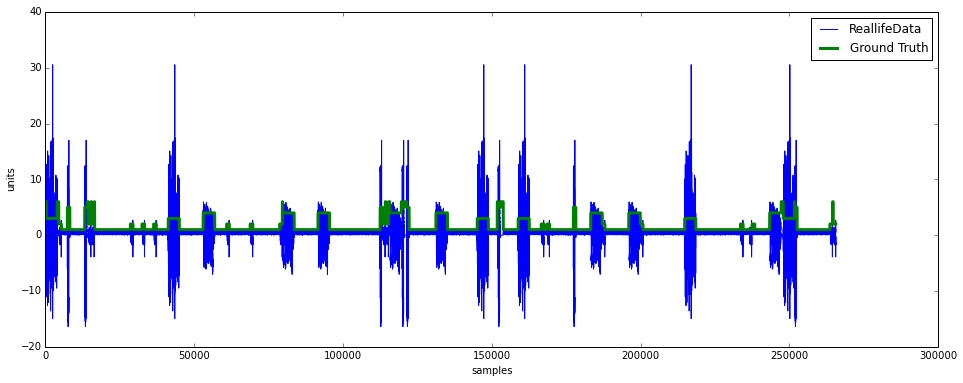

In [45]:
plt.plot(RealLife, label = "ReallifeData", color = 'b')
plt.plot(Labels, label = "Ground Truth", linewidth = 3, color = 'g')

plt.legend()
plt.xlabel('samples')
plt.ylabel('units')
plt.show()

# SAX algorithm implementation 

This algorithm is the basic approach in several motif discovery research. Please consider the provided literature for additional and detailed information. The important step in the symbolic aggregate approximation is the discretisation of the data and the conversion into symbolic strings. In this implementation the parameters <strong>wordSize</strong> and <strong>alphabetSize</strong> influnece the output of the time series respectively the symbolic representation. Please tune these two parameters and investigate differences in the generated strings.

In [46]:
class SAX(object):
    """
    This class is for computing common things with the Symbolic
    Aggregate approXimation method.  In short, this translates
    a series of data to a string, which can then be compared with other
    such strings using a lookup table.
    """

    def __init__(self, wordSize = 20, alphabetSize = 4, epsilon = 1e-6):

        if alphabetSize < 3 or alphabetSize > 20:
            raise DictionarySizeIsNotSupported()
        self.aOffset = ord('a')
        self.wordSize = wordSize
        self.alphabetSize = alphabetSize
        self.eps = epsilon
        self.breakpoints = {'3' : [-0.43, 0.43],
                            '4' : [-0.67, 0, 0.67],
                            '5' : [-0.84, -0.25, 0.25, 0.84],
                            '6' : [-0.97, -0.43, 0, 0.43, 0.97],
                            '7' : [-1.07, -0.57, -0.18, 0.18, 0.57, 1.07],
                            '8' : [-1.15, -0.67, -0.32, 0, 0.32, 0.67, 1.15],
                            '9' : [-1.22, -0.76, -0.43, -0.14, 0.14, 0.43, 0.76, 1.22],
                            '10': [-1.28, -0.84, -0.52, -0.25, 0, 0.25, 0.52, 0.84, 1.28],
                            '11': [-1.34, -0.91, -0.6, -0.35, -0.11, 0.11, 0.35, 0.6, 0.91, 1.34],
                            '12': [-1.38, -0.97, -0.67, -0.43, -0.21, 0, 0.21, 0.43, 0.67, 0.97, 1.38],
                            '13': [-1.43, -1.02, -0.74, -0.5, -0.29, -0.1, 0.1, 0.29, 0.5, 0.74, 1.02, 1.43],
                            '14': [-1.47, -1.07, -0.79, -0.57, -0.37, -0.18, 0, 0.18, 0.37, 0.57, 0.79, 1.07, 1.47],
                            '15': [-1.5, -1.11, -0.84, -0.62, -0.43, -0.25, -0.08, 0.08, 0.25, 0.43, 0.62, 0.84, 1.11, 1.5],
                            '16': [-1.53, -1.15, -0.89, -0.67, -0.49, -0.32, -0.16, 0, 0.16, 0.32, 0.49, 0.67, 0.89, 1.15, 1.53],
                            '17': [-1.56, -1.19, -0.93, -0.72, -0.54, -0.38, -0.22, -0.07, 0.07, 0.22, 0.38, 0.54, 0.72, 0.93, 1.19, 1.56],
                            '18': [-1.59, -1.22, -0.97, -0.76, -0.59, -0.43, -0.28, -0.14, 0, 0.14, 0.28, 0.43, 0.59, 0.76, 0.97, 1.22, 1.59],
                            '19': [-1.62, -1.25, -1, -0.8, -0.63, -0.48, -0.34, -0.2, -0.07, 0.07, 0.2, 0.34, 0.48, 0.63, 0.8, 1, 1.25, 1.62],
                            '20': [-1.64, -1.28, -1.04, -0.84, -0.67, -0.52, -0.39, -0.25, -0.13, 0, 0.13, 0.25, 0.39, 0.52, 0.67, 0.84, 1.04, 1.28, 1.64]
                            }
        self.beta = self.breakpoints[str(self.alphabetSize)]
        self.build_letter_compare_dict()
        self.scalingFactor = 1


    def to_letter_rep(self, x):
        """
        Function takes a series of data, x, and transforms it to a string representation
        """
        (paaX, indices) = self.to_PAA(self.normalize(x))
        self.scalingFactor = np.sqrt(len(x) / self.wordSize)
        return (self.alphabetize(paaX), indices)

    def normalize(self, x):
        """
        Function will normalize an array (give it a mean of 0, and a
        standard deviation of 1) unless it's standard deviation is below
        epsilon, in which case it returns an array of zeros the length
        of the original array.
        """
        X = np.asanyarray(x)
        if X.std() < self.eps:
            return [0 for entry in X]
        return (X-X.mean())/X.std()

    def to_PAA(self, x):
        """
        Funciton performs Piecewise Aggregate Approximation on data set, reducing
        the dimension of the dataset x to w discrete levels. returns the reduced
        dimension data set, as well as the indicies corresponding to the original
        data for each reduced dimension
        """
        n = len(x)
        stepFloat = n/float(self.wordSize)
        step = int(math.ceil(stepFloat))
        frameStart = 0
        approximation = []
        indices = []
        i = 0
        while frameStart <= n-step:
            thisFrame = np.array(x[frameStart:int(frameStart + step)])
            approximation.append(np.mean(thisFrame))
            indices.append((frameStart, int(frameStart + step)))
            i += 1
            frameStart = int(i*stepFloat)
        return (np.array(approximation), indices)

    def alphabetize(self,paaX):
        """
        Converts the Piecewise Aggregate Approximation of x to a series of letters.
        """
        alphabetizedX = ''
        for i in range(0, len(paaX)):
            letterFound = False
            for j in range(0, len(self.beta)):
                if paaX[i] < self.beta[j]:
                    alphabetizedX += chr(self.aOffset + j)
                    letterFound = True
                    break
            if not letterFound:
                alphabetizedX += chr(self.aOffset + len(self.beta))
        return alphabetizedX

    def compare_strings(self, sA, sB):
        """
        Compares two strings based on individual letter distance
        Requires that both strings are the same length
        """
        if len(sA) != len(sB):
            raise StringsAreDifferentLength()
        list_letters_a = [x for x in sA]
        list_letters_b = [x for x in sB]
        mindist = 0.0
        for i in range(0, len(list_letters_a)):
            mindist += self.compare_letters(list_letters_a[i], list_letters_b[i])**2
        mindist = self.scalingFactor* np.sqrt(mindist)
        return mindist

    def compare_letters(self, la, lb):
        """
        Compare two letters based on letter distance return distance between
        """
        return self.compareDict[la+lb]

    def build_letter_compare_dict(self):
        """
        Builds up the lookup table to determine numeric distance between two letters
        given an alphabet size.  Entries for both 'ab' and 'ba' will be created
        and will have identical values.
        """

        number_rep = range(0,self.alphabetSize)
        letters = [chr(x + self.aOffset) for x in number_rep]
        self.compareDict = {}
        for i in range(0, len(letters)):
            for j in range(0, len(letters)):
                if np.abs(number_rep[i]-number_rep[j]) <=1:
                    self.compareDict[letters[i]+letters[j]] = 0
                else:
                    high_num = np.max([number_rep[i], number_rep[j]])-1
                    low_num = np.min([number_rep[i], number_rep[j]])
                    self.compareDict[letters[i]+letters[j]] = self.beta[high_num] - self.beta[low_num]

    def sliding_window(self, x, numSubsequences = None, overlappingFraction = None):
        if not numSubsequences:
            numSubsequences = 20
        self.windowSize = int(len(x)/numSubsequences)
        if not overlappingFraction:
            overlappingFraction = 0.9
        overlap = self.windowSize*overlappingFraction
        moveSize = int(self.windowSize - overlap)
        if moveSize < 1:
            raise OverlapSpecifiedIsNotSmallerThanWindowSize()
        ptr = 0
        n = len(x)
        windowIndices = []
        stringRep = []
        while ptr < n-self.windowSize+1:
            thisSubRange = x[ptr:ptr+self.windowSize]
            (thisStringRep,indices) = self.to_letter_rep(thisSubRange)
            stringRep.append(thisStringRep)
            windowIndices.append((ptr, ptr+self.windowSize))
            ptr += moveSize
        return (stringRep,windowIndices)

    def batch_compare(self, xStrings, refString):
        return [self.compare_strings(x, refString) for x in xStrings]

    def set_scaling_factor(self, scalingFactor):
        self.scalingFactor = scalingFactor

    def set_window_size(self, windowSize):
        self.windowSize = windowSize

### Testing the SAX algorithm
You can adapt the parameters of the SAX algoritm and check how the output stream changes: the parametes which you can adapt are: wordSize = n, alphabetSize = n. These parameters can also be changed in the VizTree application.

Test with random data.

In [47]:
s = pd.Series(np.random.randn(100), name='something') # generate some random data.

In [48]:
#s

In [49]:
sx = SAX() # first an instance of the SAX object needs to be created.

In [50]:
RandomSymbols = sx.to_letter_rep(s) # The output is denoted as RandomSymbols.
#RandomSymbols

In [51]:
type(RandomSymbols)

tuple

Symbols is of type tuple thus we can extract the symbols by symbols[0] and the time stamp by symbols[1]

In [52]:
RandomSymbols[0]  #symbols[1]

'bbccbcbbccbdbbbbbcbd'

Check what happens when you use a periodic signal, e.g. a sine wave. Also play with the parameters and observe the changes in the symbolic string.

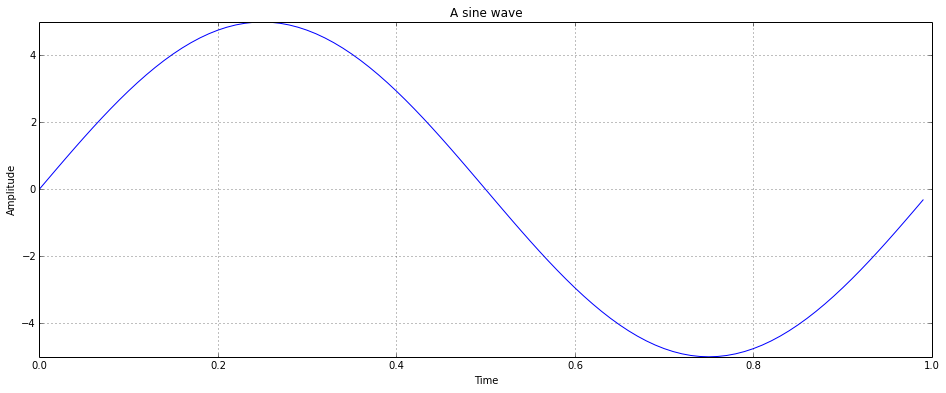

In [53]:
t = arange(0.0, 1, 0.01)
y = 5*sin(2*pi*t)
fig = figure(1)

ax1 = fig.add_subplot(111)
ax1.plot(t, y)
ax1.grid(True)
ax1.set_ylim((-5, 5))
ax1.set_xlabel('Time')
ax1.set_ylabel('Amplitude')
ax1.set_title('A sine wave')

show()

In [54]:
sine_sx = SAX() 
Sine_Symbols = sine_sx.to_letter_rep(sin(2*pi*t)) 
Sine_Symbols[0]

'ccdddddddcbbaaaaaaab'

In [55]:
Segments = Sine_Symbols[1] # indicates where the time serise is segmente
#Segments

In [56]:
A = Segments[1]
A[0]

5

In [57]:
s = np.empty(len(Segments))
seg = []
for i in range(len(Segments)):
    helper = Segments[i]
    s = helper[0]
    seg.append(s)
    #print(s)

In [58]:
print("Time series length: ", len(y))
print("Symbolic representation - Length of String: ", len(Sine_Symbols[0]))
print("N of samples in in one segment:", len(Sine_Symbols[0])/len(y))
print("N of symbols to describe the segment:", len(Sine_Symbols[0])/len(y))

Time series length:  100
Symbolic representation - Length of String:  20
N of samples in in one segment: 0.2
N of symbols to describe the segment: 0.2


Test the SAX by comparison of the two ecg signals. You can use the functionality "Comparison" which allows you to compare two symbolic strings. The example below show you the score, first when comparing the two different ecg signals (ref and abn), secondly to show the comparison value we compare the same signal and expect a complete "match" of the string, thus the error (or difference value) needs to be zero!
The comparison is a suitable function which you can use for the development of your ideas and implementation steps.
Please read also the README.txt of the provided SAX algorithm to explore further possibilities of the SAX class.

In [59]:
ECGref_sx = SAX() 
ECGabn_sx = SAX() 
(ECGref_Symbols, ECGref_Idx)= sine_sx.to_letter_rep(ECG_ref) 
(ECGabn_Symbols,ECGabn_Idx) = sine_sx.to_letter_rep(ECG_abn)

In [60]:
ref_abn_ComparisonScore = sx.compare_strings(ECGref_Symbols, ECGabn_Symbols) # two different signals compared
ref_abn_ComparisonScore # we have a difference
print("The difference between the two strings is: ", ref_abn_ComparisonScore)

The difference between the two strings is:  1.49816554492


In [61]:
ref_abn_ComparisonScore = sx.compare_strings(ECGref_Symbols, ECGref_Symbols) # the same signals compared
ref_abn_ComparisonScore # we have no difference
print("The difference between the two strings is: ", ref_abn_ComparisonScore)

The difference between the two strings is:  0.0


In a similar fashion of analysing the two different ecg signals you can analyse the random time series:
    symbols = sx.to_letter_rep(RandomTS)

## Real life data as provided by the data sets "ActivitySparse" and "ActivityDense"

In [64]:
len(RealLife)

265582

In [65]:
Real_sx = SAX() 
Real_Symbols = Real_sx.to_letter_rep(RealLife) 
#Real_Symbols[0]

In [66]:
len(Real_Symbols[0])

20

In [67]:
Segments = Real_Symbols[1] # indicates where the time serise is segmente
#Segments

In [68]:
s = np.empty(len(Segments))
seg = []
for i in range(len(Segments)):
    helper = Segments[i]
    s = helper[0]
    seg.append(s)
    #print(s)

In [69]:
print("Time series length: ", len(RealLife))
print("Symbolic representation - Length of String: ", len(Real_Symbols[0]))
print("N of samples in in one segment:", len(RealLife)/len(Real_Symbols[0]))
print("N of samples described by one symbol:", len(RealLife)/len(Real_Symbols[0]))

Time series length:  265582
Symbolic representation - Length of String:  20
N of samples in in one segment: 13279.1
N of samples described by one symbol: 13279.1


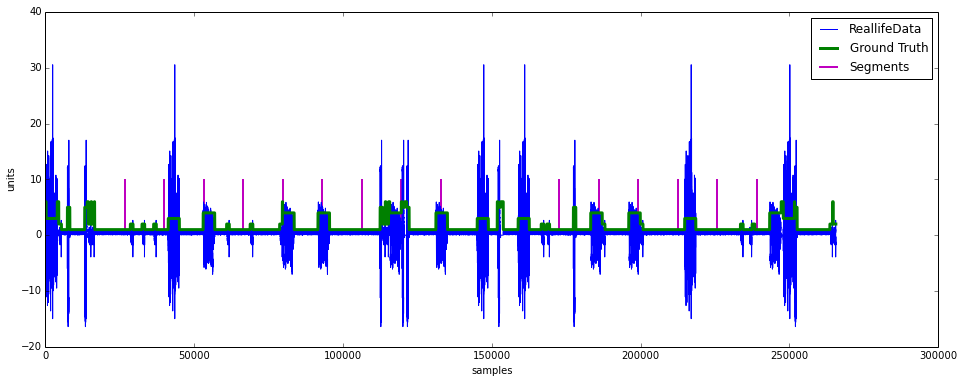

In [70]:
plt.plot(RealLife, label = "ReallifeData", color = 'b')
plt.plot(Labels, label = "Ground Truth", linewidth = 3, color = 'g')
plt.vlines(seg[:100], ymin=0, ymax = 10, linewidth=2, color='m', label = "Segments")
plt.legend()
plt.xlabel('samples')
plt.ylabel('units')
plt.show()

# Your motif discovery implementation begins here!

As already introduced in the task description, here the reminder of an approach which you can consider as starting point.

<img src="Approach.png" />

<img src="TimeSeries.png" />

# Evaluation step - Compare your discovered motifs with the ground truth
In the evaluation step you have the possibility to verify your motif search algorithms on the small random time series <strong>RandomTS</strong> or on the real life data set <strong>RealLife</strong> since we provide you the labels (Ground Truth) for the different motifs (in this case its activites and gestures respectively).
With the ground truth provided you shall check if your algorithm discovered a motif at the right time (location within the time series) and if the discoverd motif belong to the same class. Again, it is not of relevance what the class represents, but you can get this information from the supervisor.